# Week 1: How Markets Work & Financial Data

> *"The stock market is the only market where things go on sale and all the customers run out of the store."*
> -- Attributed to various (and probably apocryphal, like most good finance quotes)

## The Journey from Click to Catastrophe

Let's start with a deceptively simple scenario. You open your phone, tap "Buy 100 shares of AAPL," and two seconds later you get a confirmation. Done. You own Apple stock.

Except nothing about that transaction was simple. In those two seconds, your order traveled from your phone to your broker's servers, was analyzed by a smart order router that decided -- in microseconds -- which of a dozen execution venues would give you the best price, was potentially routed to a wholesaler like Citadel Securities (who handles roughly 25% of all US equity volume), was matched against a resting limit order posted by an algorithmic market maker, was reported to the consolidated tape, and was queued for settlement two business days later through the DTCC. And every single step in that pipeline left fingerprints in the data you'll eventually feed to a model.

This week, we're going to trace that journey end to end. Not because the plumbing is intrinsically fascinating (though it kind of is), but because **if you don't understand where financial data comes from, you will build models that learn from ghosts.** An adjusted close price embeds decisions about how to handle stock splits and dividends. A "complete" dataset of S&P 500 stocks is quietly missing every company that went bankrupt. A daily bar compresses tens of thousands of individual trades into four numbers, erasing the microstructure that generated them.

By the end of this lecture, you'll look at a CSV of stock prices with the healthy suspicion it deserves. You'll know which column to use (and which one will inject phantom crashes into your training data). You'll understand why your backtest returns are probably too high. And you'll have the vocabulary to talk to people who do this for a living -- because everything we cover today is someone's full-time job at a quantitative fund.

Let's start at the beginning: what actually happens when you click "buy"?

In [1]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import polars as pl
import yfinance as yf

# ── Matplotlib defaults ──
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11,
})

np.random.seed(42)

# ── Data parameters ──
TICKERS = ["AAPL", "TSLA", "JPM", "SPY", "GE"]
START = "2010-01-01"
END = "2025-01-01"

---

## Section 1: How a Trade Actually Happens

You click "buy AAPL" on your phone. What happens in the next 50 microseconds? Spoiler: your order probably never touches the NYSE.

Here's something most people outside the industry don't realize: when you place a market order through Robinhood, Schwab, or Fidelity, the most likely path is *not* to the New York Stock Exchange. Your order goes to your broker, who passes it to a **smart order router** -- a piece of software that evaluates, in real time, a dozen possible execution venues and picks the one that gives you the best deal (or, more cynically, the one that gives the broker the best economics). Those venues include the traditional exchanges (NYSE, Nasdaq), dark pools (private venues where large institutions trade without revealing their intentions), and wholesalers like Citadel Securities or Virtu Financial that internalize retail order flow.

The matching itself happens in microseconds. A matching engine at an exchange uses **price-time priority** -- the best-priced order gets filled first, and among equal prices, the one that arrived first wins. There are three order types you need to know: **market orders** ("fill me now at whatever price is available" -- fast but price-uncertain), **limit orders** ("fill me only at $150 or better" -- price-certain but execution-uncertain), and **stop orders** ("become a market order if the price hits $140" -- a conditional trigger). Every quant model that generates trades has to decide which type to use, and that decision has real cost implications.

The flowchart below traces a single AAPL market buy order from your phone to execution. Pay attention to the latency annotations -- the time scale shrinks by three orders of magnitude as you move from human interaction to electronic matching.

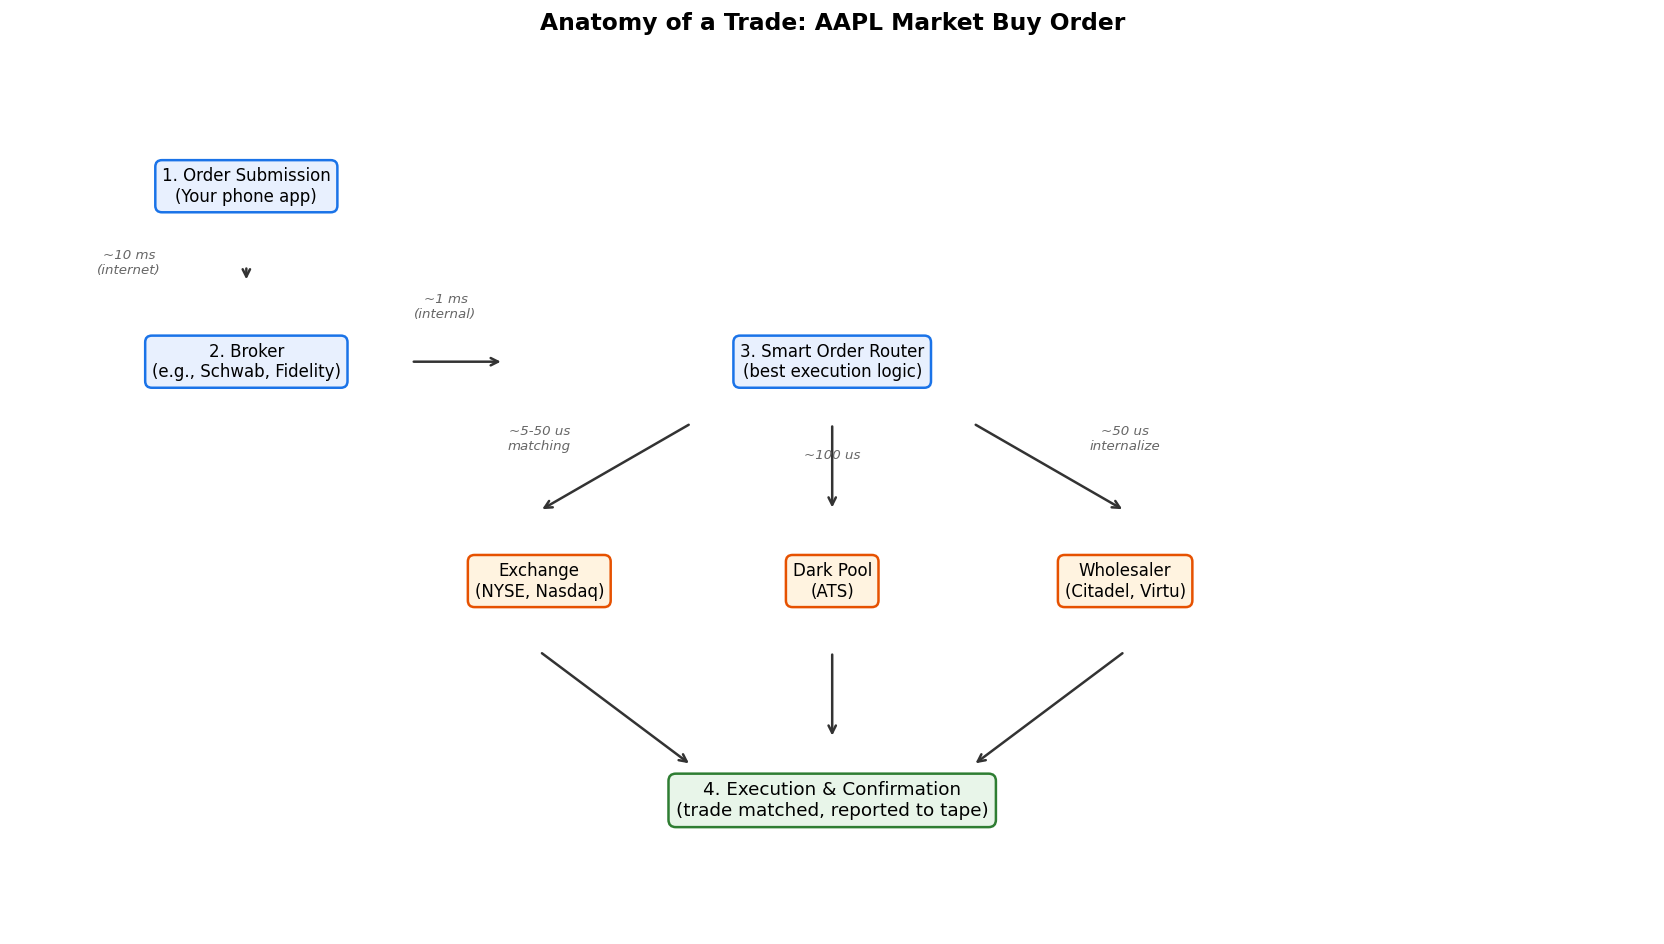

In [2]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 14); ax.set_ylim(0, 10); ax.axis("off")

box = dict(boxstyle="round,pad=0.4", facecolor="#E8F0FE", edgecolor="#1A73E8", lw=1.5)
venue = dict(boxstyle="round,pad=0.4", facecolor="#FFF3E0", edgecolor="#E65100", lw=1.5)
done = dict(boxstyle="round,pad=0.4", facecolor="#E8F5E9", edgecolor="#2E7D32", lw=1.5)
lat = dict(fontsize=8, fontstyle="italic", color="#666666", ha="center")
arrow_kw = dict(arrowstyle="->", color="#333333", linewidth=1.5)

ax.text(2, 8.5, "1. Order Submission\n(Your phone app)", ha="center", va="center", fontsize=10, bbox=box)
ax.text(2, 6.5, "2. Broker\n(e.g., Schwab, Fidelity)", ha="center", va="center", fontsize=10, bbox=box)
ax.text(7, 6.5, "3. Smart Order Router\n(best execution logic)", ha="center", va="center", fontsize=10, bbox=box)
ax.text(4.5, 4.0, "Exchange\n(NYSE, Nasdaq)", ha="center", va="center", fontsize=10, bbox=venue)
ax.text(7, 4.0, "Dark Pool\n(ATS)", ha="center", va="center", fontsize=10, bbox=venue)
ax.text(9.5, 4.0, "Wholesaler\n(Citadel, Virtu)", ha="center", va="center", fontsize=10, bbox=venue)
ax.text(7, 1.5, "4. Execution & Confirmation\n(trade matched, reported to tape)", ha="center", va="center", fontsize=11, bbox=done)

for xy, xytext in [((2,7.4),(2,7.6)), ((4.2,6.5),(3.4,6.5)), ((4.5,4.8),(5.8,5.8)),
    ((7,4.8),(7,5.8)), ((9.5,4.8),(8.2,5.8)), ((5.8,1.9),(4.5,3.2)),
    ((7,2.2),(7,3.2)), ((8.2,1.9),(9.5,3.2))]:
    ax.annotate("", xy=xy, xytext=xytext, arrowprops=arrow_kw)

ax.text(1.0, 7.5, "~10 ms\n(internet)", **lat); ax.text(3.7, 7.0, "~1 ms\n(internal)", **lat)
ax.text(4.5, 5.5, "~5-50 us\nmatching", **lat); ax.text(7, 5.4, "~100 us", **lat)
ax.text(9.5, 5.5, "~50 us\ninternalize", **lat)
ax.set_title("Anatomy of a Trade: AAPL Market Buy Order", fontsize=14, fontweight="bold", pad=15)
plt.tight_layout()
plt.show()

Look at those latency numbers. Your phone takes about 10 milliseconds to send the order to your broker -- that's the slowest step, limited by the speed of light through fiber optic cable. By the time the order reaches the matching engine, we're in microsecond territory. The exchange matches orders in 5-50 microseconds. A wholesaler like Citadel can internalize your order in about 50 microseconds. For context, a human blink takes 300,000 microseconds. The entire trade execution happens faster than you can physically perceive it.

This matters for your ML models because **latency determines what data you can realistically use.** If you build a model that needs 500 milliseconds to generate a prediction, you're operating in a different universe than the firms making decisions in 5 microseconds. The data that drives their strategies (tick-by-tick order flow, order book imbalances) is fundamentally different from the data that drives yours (daily bars, fundamental ratios). Knowing where you sit in this latency hierarchy determines what's even worth modeling.

Every order that enters this system lands in a structure called the **order book**. That's where price discovery actually happens -- and it's what we'll look at next.

---

## Section 2: The Order Book -- Where Price Discovery Lives

The price you see on Google Finance is not "the price." It's the **last trade price** -- a historical artifact, the price at which the most recent transaction occurred. It could be one second old or one hour old. The real action is happening in the order book, which most retail investors never see.

Think of the order book as two queues facing each other. On one side, buyers line up with the prices they're willing to pay (the **bids**). On the other side, sellers line up with the prices they'll accept (the **asks**). The gap between the best bid and the best ask is the **spread** -- and you pay it every time you trade. It's the market's admission fee.

When someone says "AAPL is at $190," what they usually mean is that the last trade happened at $190. But the order book might show the best bid at $189.99 and the best ask at $190.01. The **mid-price** ($190.00) is the best estimate of fair value -- it's the midpoint between what buyers and sellers are willing to do. The spread (2 cents in this case) is what you surrender to participate.

For Apple, that 2-cent spread on a $190 share is about 1 basis point -- barely noticeable. For a micro-cap stock, the spread can be 50 cents on a $5 share -- that's 10%. Your model needs to be right by more than 10% just to break even on a round trip. Most models aren't right by 1%.

Let's build a synthetic order book and see how it behaves. We'll create 10 price levels on each side, with realistic-looking volumes, and then watch what happens when a large order hits.

In [3]:
mid_price = 150.00
tick_size = 0.01
n_levels = 10

bid_prices = np.array([mid_price - tick_size * (i + 1) for i in range(n_levels)])
ask_prices = np.array([mid_price + tick_size * (i + 1) for i in range(n_levels)])

bid_volumes = np.random.randint(100, 800, size=n_levels).astype(float)
ask_volumes = np.random.randint(100, 800, size=n_levels).astype(float)

best_bid = bid_prices[0]
best_ask = ask_prices[0]
spread_before = best_ask - best_bid
print(f"Best bid: ${best_bid:.2f}  |  Best ask: ${best_ask:.2f}")
print(f"Spread: ${spread_before:.4f}  ({spread_before / mid_price * 10000:.1f} bps)")
print(f"Mid-price: ${mid_price:.2f}")

Best bid: $149.99  |  Best ask: $150.01
Spread: $0.0200  (1.3 bps)
Mid-price: $150.00


A 2-cent spread on a $150 stock -- about 1.3 basis points. That's typical for a large-cap, liquid equity during market hours. It seems negligible, and for a buy-and-hold investor it essentially is. But for a systematic trading strategy that trades 200 times a day, that penny-per-share friction compounds to about 25% of capital per year. We'll quantify this precisely in the seminar.

Now let's visualize the book. Bids on the left (green -- these are buyers willing to catch falling prices), asks on the right (red -- sellers demanding higher prices). The gap in the center is the spread. Think of it as two armies facing each other across a narrow no-man's land.

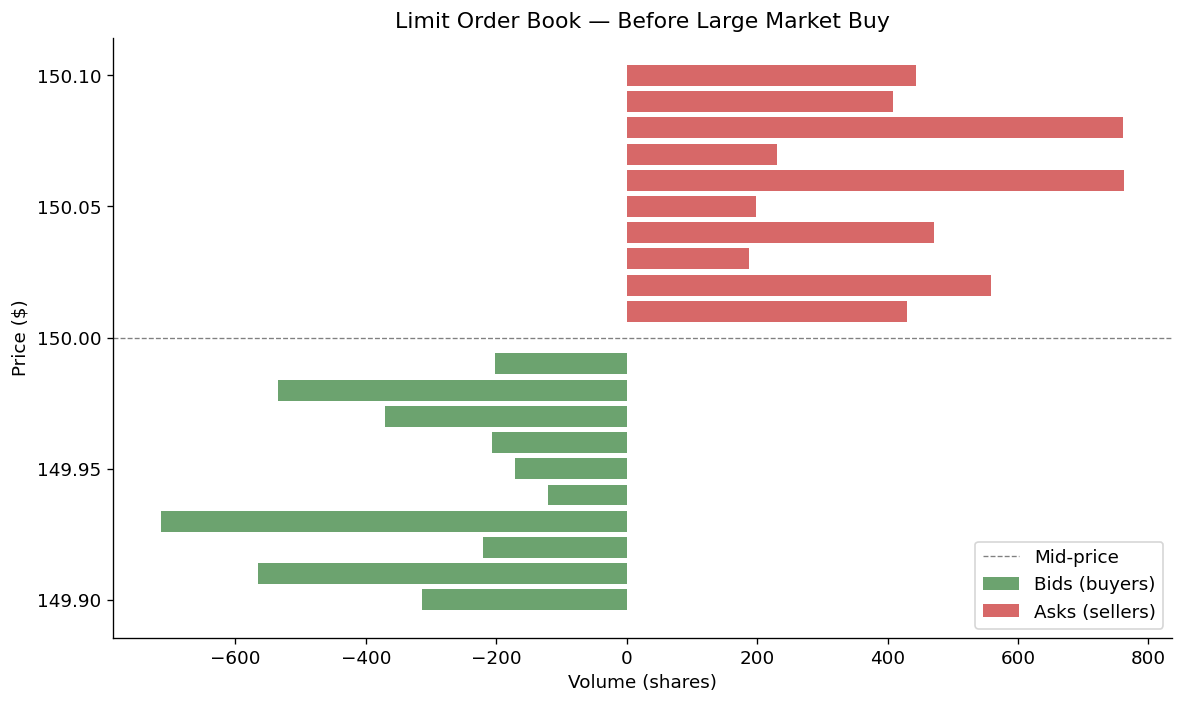

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(bid_prices, -bid_volumes, height=tick_size * 0.8,
        color="#2E7D32", alpha=0.7, label="Bids (buyers)")
ax.barh(ask_prices, ask_volumes, height=tick_size * 0.8,
        color="#C62828", alpha=0.7, label="Asks (sellers)")

ax.axhline(mid_price, color="gray", linestyle="--", linewidth=0.8, label="Mid-price")
ax.set_xlabel("Volume (shares)")
ax.set_ylabel("Price ($)")
ax.set_title("Limit Order Book — Before Large Market Buy")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

Notice the volume distribution: some price levels have thick bars (lots of liquidity), others are thin. That unevenness isn't random in real markets -- it reflects where different participants have placed their bets. HFT firms monitor the volume ratio between bid and ask sides (the **order book imbalance**), updating their models every 50 microseconds. A book that's heavier on the bid side -- more buyers than sellers -- often predicts short-term upward price movement. We'll work with this signal formally in Week 13 when we cover market microstructure features.

Here's an important nuance that many data-first people miss: you're looking at **L2 data** (full order book depth). Most free data sources give you only **L1** -- the best bid and best ask. That single number (the spread) compresses all this depth information into one dimension. L2 data is where the rich microstructure signals live, but it costs real money and generates enormous volumes (NYSE alone produces roughly 1 TB of message data per day).

Now let's see what happens when a large buyer arrives. We'll simulate a 2,000-share market buy order eating through the ask side of the book. Watch how the price moves against the buyer.

In [5]:
market_buy_size = 2000
remaining = market_buy_size
filled_prices = []
filled_volumes = []
post_ask_volumes = ask_volumes.copy()

for i in range(n_levels):
    if remaining <= 0:
        break
    fill = min(remaining, post_ask_volumes[i])
    filled_prices.append(ask_prices[i])
    filled_volumes.append(fill)
    post_ask_volumes[i] -= fill
    remaining -= fill

avg_fill_price = np.average(filled_prices, weights=filled_volumes)
levels_consumed = sum(1 for v in filled_volumes if v > 0)

new_best_ask = ask_prices[np.argmax(post_ask_volumes > 0)]
spread_after = new_best_ask - best_bid

print(f"Market buy: {market_buy_size} shares")
print(f"Levels consumed: {levels_consumed}")
print(f"Average fill price: ${avg_fill_price:.4f}")
print(f"New best ask: ${new_best_ask:.2f}  (was ${best_ask:.2f})")
print(f"Spread after: ${spread_after:.4f}  (was ${spread_before:.4f})")

Market buy: 2000 shares
Levels consumed: 6
Average fill price: $150.0296
New best ask: $150.06  (was $150.01)
Spread after: $0.0700  (was $0.0200)


This is **market impact** in its purest form. The 2,000-share order didn't execute at one price -- it consumed multiple levels of the ask side, pushing the price higher with each level. The buyer's average fill price was above the initial best ask, and the spread widened because the nearby ask liquidity was eaten. This is exactly why institutional traders don't just slam market orders into the book. They use algorithms like VWAP (Volume-Weighted Average Price) and TWAP (Time-Weighted Average Price) to slice large orders into hundreds of small pieces spread across time, minimizing the footprint in the book.

For ML practitioners, here's the key insight: **the price you see in historical data is not the price you'd get.** Your model might say "buy 10,000 shares at $150.01" -- but by the time you've executed, you've pushed the price to $150.05 and your expected profit just shrank by 4 cents per share. This gap between the backtest price and the actual execution price is called **slippage**, and ignoring it is how backtests that look brilliant on paper turn into strategies that bleed money in production.

Let's see what the post-impact book looks like.

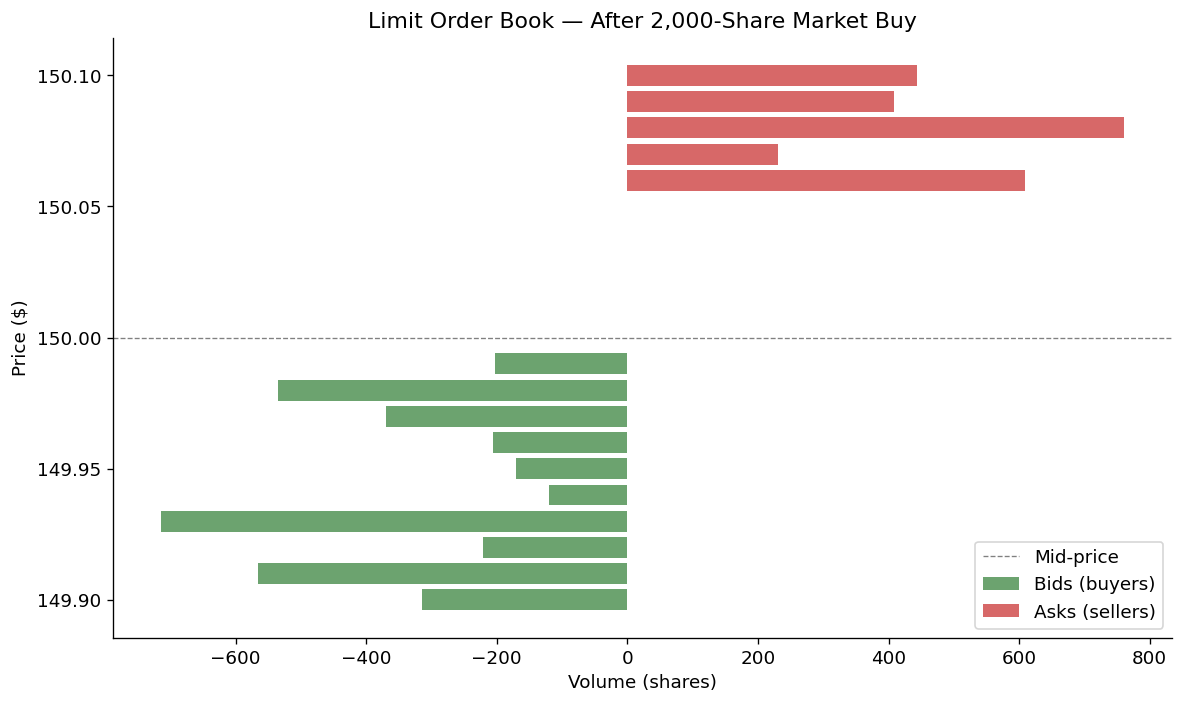

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(bid_prices, -bid_volumes, height=tick_size * 0.8,
        color="#2E7D32", alpha=0.7, label="Bids (buyers)")
ax.barh(ask_prices, post_ask_volumes, height=tick_size * 0.8,
        color="#C62828", alpha=0.7, label="Asks (sellers)")

ax.axhline(mid_price, color="gray", linestyle="--", linewidth=0.8, label="Mid-price")
ax.set_xlabel("Volume (shares)")
ax.set_ylabel("Price ($)")
ax.set_title("Limit Order Book — After 2,000-Share Market Buy")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

Compare this to the "before" chart above. The ask side near the top is depleted -- those first few levels have been consumed or partially filled. The spread is visibly wider. In a real market, new limit orders would flow in to refill those depleted levels within milliseconds. But during that brief window of widened spread, anyone else trading pays a higher cost. This is the ripple effect of market impact -- one large order temporarily degrades the market quality for everyone.

The SEC's November 2025 round-lot reform adds an interesting wrinkle here. Historically, the "official" best bid and ask -- the National Best Bid and Offer (NBBO) -- only counted round lots of 100 shares. A single share offered at a better price was invisible to the system. The reform introduced price-tiered lot sizes: stocks above $250 can now have smaller round lots (40, 10, or even 1 share). Starting May 2026, the consolidated tape will disseminate odd-lot quotes priced at or better than the NBBO. For data scientists, this means the spread data you download after mid-2026 will look structurally different from pre-reform data. Keep that in mind if you're training on long historical windows.

The spread is the market maker's compensation. But who are market makers, and why do they exist?

---

## Section 3: Market Makers -- The Invisible Infrastructure

Citadel Securities -- one company -- executes about 25% of all US equity volume. They're not a hedge fund (that's Citadel LLC, a completely separate entity run by the same person). They're the *plumbing*. Every time your Robinhood order fills, there's a good chance it went through them. They made $7.5 billion in revenue in 2022. On pennies per share.

Market makers solve a fundamental coordination problem: when you want to buy, there might not be a natural seller at that exact moment. The market maker stands in the middle, continuously posting bids and asks, willing to take the other side of your trade. They earn the **spread** as compensation -- buy at the bid, sell at the ask, pocket the difference. Repeat a few million times a day.

This sounds like free money, and it nearly is -- when the order flow is **uninformed**. A retail investor buying 50 shares of AAPL because they like iPhones is not moving the market. The market maker sells at $190.01, the price doesn't move, and they cover at $190.00 a minute later. Spread captured, risk minimal.

But here's the catch: some orders are **informed**. A hedge fund that just ran a sophisticated NLP model on AAPL's earnings transcript and knows (with some probability) that the price is about to drop -- that fund's sell order is toxic to the market maker. The market maker buys at the bid, the price drops, and they're stuck holding a depreciating asset. This is **adverse selection**, and it's the market maker's central risk.

This is also why **Payment for Order Flow (PFOF)** exists. Wholesalers like Citadel Securities pay brokers like Robinhood for the privilege of executing retail orders. Why? Because retail orders are statistically uninformed -- they're the "easy" flow. The wholesaler can internalize these orders, earn a predictable spread, and avoid the toxic institutional flow on public exchanges. The EU banned PFOF under MiFID III in 2025; the US hasn't. This creates a useful natural experiment for researchers studying how market structure is a regulatory choice, not a law of physics.

Let's simulate this. We'll run a market maker through 500 trades under two scenarios: one with entirely uninformed (random) order flow, and one where half the traders are informed.

In [7]:
n_trades = 500
spread = 0.10
half_spread = spread / 2
price_volatility = 0.50


def simulate_market_maker(n_trades, informed_fraction):
    """Simulate a market maker facing a mix of informed/uninformed orders."""
    pnl = np.zeros(n_trades)
    for i in range(n_trades):
        is_informed = np.random.random() < informed_fraction
        if is_informed:
            price_move = np.random.normal(0, price_volatility)
            pnl[i] = half_spread - abs(price_move)
        else:
            pnl[i] = half_spread
    return np.cumsum(pnl)

The model is simple but captures the essential economics. When an uninformed trader arrives, the market maker earns the half-spread cleanly -- no adverse price movement, pure profit. When an informed trader arrives, the market maker still earns the half-spread, but the price moves against them by an amount proportional to the volatility. If the price move exceeds the spread, the market maker loses money on that trade. The question is whether the uninformed profits can cover the informed losses. Let's find out.

In [8]:
pnl_uninformed = simulate_market_maker(n_trades, informed_fraction=0.0)
print(f"Uninformed flow — Final P&L: ${pnl_uninformed[-1]:.2f}")
print(f"  Per-trade avg: ${pnl_uninformed[-1] / n_trades:.4f}")

Uninformed flow — Final P&L: $25.00
  Per-trade avg: $0.0500


With 100% uninformed flow, the market maker's P&L climbs in a perfect straight line -- every trade earns exactly the half-spread, no exceptions. This is the theoretical ideal and the economic rationale for market making: if all you face is random noise, you're running a toll booth on a highway. Now let's introduce some informed traders and see what happens to those toll booth economics.

In [9]:
pnl_informed = simulate_market_maker(n_trades, informed_fraction=0.5)
print(f"Informed flow (50%) — Final P&L: ${pnl_informed[-1]:.2f}")
print(f"  Per-trade avg: ${pnl_informed[-1] / n_trades:.4f}")

Informed flow (50%) — Final P&L: $-78.53
  Per-trade avg: $-0.1571


The difference is stark. With half the flow coming from informed traders, the market maker's profitability collapses. The spread income from uninformed traders can't compensate for the adverse selection losses from the informed ones. In real markets, market makers manage this by **widening spreads** when they detect informed flow (making it more expensive for everyone to trade) and by using sophisticated models to estimate the probability that any given order is informed.

If you're coming from ML, think of it this way: adverse selection is a distribution shift problem. The market maker's "model" (quoting a fixed spread) works beautifully on the training distribution (uninformed flow) but fails catastrophically on the shifted distribution (informed flow). The solution is the same as in ML -- you need to detect the shift and adapt. We'll see formal models for this (Avellaneda-Stoikov, for example) later in the course.

Let's visualize both P&L paths side by side. Look for the divergence point -- where the informed losses start overwhelming the spread income.

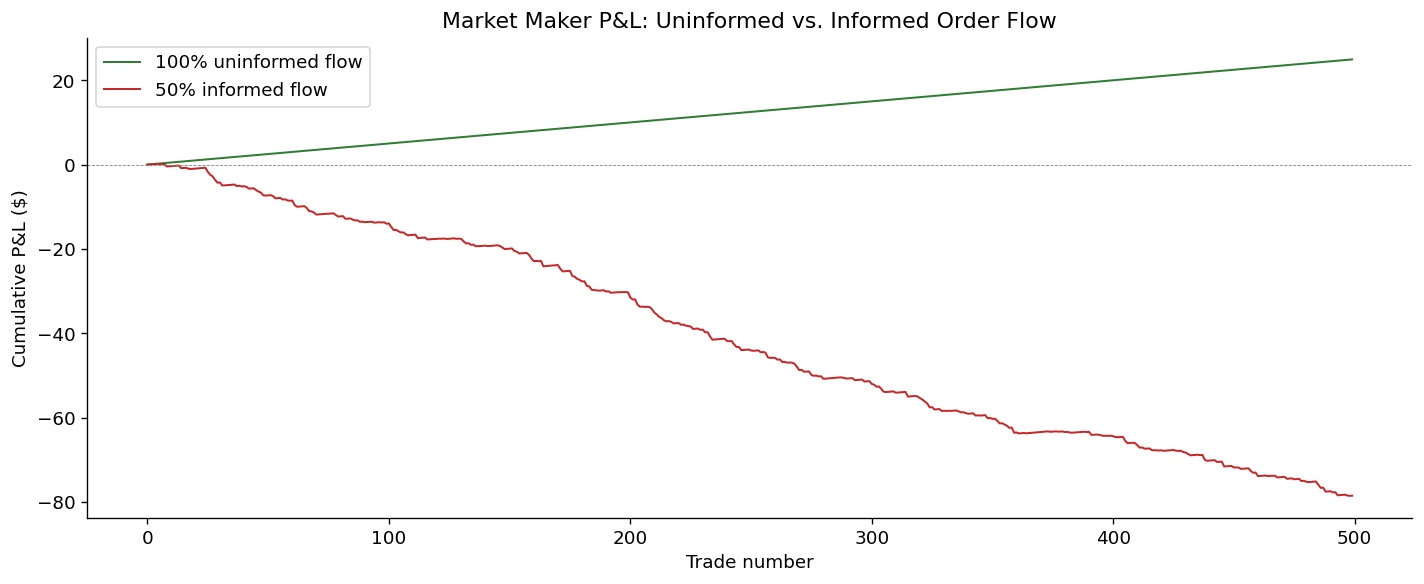

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(pnl_uninformed, label="100% uninformed flow", color="#2E7D32", linewidth=1.2)
ax.plot(pnl_informed, label="50% informed flow", color="#C62828", linewidth=1.2)
ax.axhline(0, color="gray", linestyle="--", linewidth=0.5)

ax.set_xlabel("Trade number")
ax.set_ylabel("Cumulative P&L ($)")
ax.set_title("Market Maker P&L: Uninformed vs. Informed Order Flow")
ax.legend()
plt.tight_layout()
plt.show()

The green line (uninformed) climbs steadily -- a money-printing machine. The red line (50% informed) is volatile and may even trend negative, depending on the random draws. The gap between these two lines *is the entire business model of Payment for Order Flow.* Citadel Securities pays Robinhood for retail orders precisely because those orders look like the green line, not the red one. Retail flow is gold; institutional flow is poison.

This has direct implications for anyone building trading strategies. If your model is good enough to be "informed," you're the red line for the market maker. They'll detect your flow patterns, widen spreads against you, and your execution costs will quietly increase until your edge disappears. This is why transaction cost modeling isn't optional -- it's the difference between a backtest that looks great and a strategy that actually makes money. But that's a topic for Week 13.

Market makers, exchanges, and brokers together produce a torrent of data -- NYSE alone generates roughly 1 TB of message data per day. Nobody builds ML models on raw ticks. So how does that data get turned into something usable?

---

## Section 4: From Tick Data to OHLCV Bars -- The Aggregation Pipeline

A single trading day for AAPL generates tens of thousands of individual trades. You'll work with four numbers: Open, High, Low, Close. What gets lost in that compression -- and does it matter?

The answer is: it matters enormously, and the compression is lossy in ways that aren't obvious. Every daily OHLCV bar summarizes the full intraday drama into five fields. The **Open** is the first trade of the day (itself an artifact of the opening auction mechanism). The **High** and **Low** are the extreme prices -- the maximum and minimum that any trade hit. The **Close** is the last trade (or, on some exchanges, the result of a closing auction). And **Volume** is the total number of shares traded. Thousands of trades, compressed into one row.

What's lost? Everything about *when* within the day the extremes occurred. Whether the high came at 9:31 AM (opening volatility) or 3:55 PM (closing rush). Whether volume was concentrated in one burst or spread evenly. Whether the price dropped to the low and recovered, or hit the high and collapsed. All of that microstructure is erased. For daily-frequency models, this is usually acceptable. For intraday models, it's catastrophic -- which is why alternative bar types (volume bars, dollar bars, tick bars) exist. We'll revisit those in Week 13.

The other field to understand is **Adjusted Close** -- a synthetic number that retroactively modifies all historical prices to account for stock splits and dividends. We'll tear this apart in Section 6. For now, just know it exists and that choosing the wrong column is one of the most common data errors in quantitative research.

Let's download real data and look at the structure.

In [11]:
raw = yf.download(TICKERS, start=START, end=END, auto_adjust=False)
close = raw["Close"]

print(f"Shape: {raw.shape}")
print(f"Date range: {raw.index[0].date()} to {raw.index[-1].date()}")
print(f"Columns: {list(raw.columns.get_level_values(0).unique())}")
close.head()

[                       0%                       ]

[*******************   40%                       ]  2 of 5 completed

[**********************60%****                   ]  3 of 5 completed

[*********************100%***********************]  5 of 5 completed

Shape: (3774, 30)
Date range: 2010-01-04 to 2024-12-31
Columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']


Ticker,AAPL,GE,JPM,SPY,TSLA
Date,,,,,
2010-01-04,7.643214,74.043159,42.849998,113.330002,NaN
2010-01-05,7.656429,74.426552,43.680000,113.629997,NaN
2010-01-06,7.534643,74.043159,43.919998,113.709999,NaN
2010-01-07,7.520714,77.877106,44.790001,114.190002,NaN
2010-01-08,7.570714,79.554459,44.680000,114.570000,NaN


Five columns, one row per trading day, about 252 rows per year. This is the atomic unit of most quantitative research -- and the starting point for nearly every ML model in finance. But raw prices are *terrible* features for a model. AAPL at $30 in 2010 and AAPL at $190 in 2024 are the same company at different times. A model trained on prices has to learn that these numbers mean the same thing, which is asking a lot. This is equivalent to training an image classifier on images where the same object appears at wildly different scales with no normalization.

The fix is simple: work with **returns** instead of prices. The simple daily return measures the percentage change from one day to the next:

$$r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$

Returns have a critical property that prices don't: they're approximately **stationary** (the statistical properties don't change much over time). A 2% daily return meant roughly the same thing in 2010 as it does in 2024. Let's compute them and see the difference.

In [12]:
returns = close.pct_change().dropna()
returns.describe().round(4)

Ticker,AAPL,GE,JPM,SPY,TSLA
count,3651.0000,3651.0000,3651.0000,3651.0000,3651.0000
mean,0.0011,0.0004,0.0007,0.0005,0.0022
std,0.0175,0.0198,0.0174,0.0107,0.0361
min,-0.1286,-0.1516,-0.1496,-0.1094,-0.2106
25%,-0.0075,-0.0085,-0.0076,-0.0038,-0.0161
50%,0.0009,0.0000,0.0005,0.0006,0.0013
75%,0.0102,0.0091,0.0089,0.0058,0.0194
max,0.1198,0.1473,0.1801,0.0906,0.2440


Look at the mean daily returns: they're all very close to zero. That's not a coincidence -- it's a **stylized fact** of financial returns ("stylized fact" is finance jargon for a statistical regularity that holds across markets, time periods, and asset classes). Daily returns are approximately mean-zero and symmetric. Prices are not -- they trend, they grow exponentially, they span different numerical ranges for different stocks.

Now look at the standard deviations. TSLA's daily vol is roughly double JPM's. And check the min/max: those extreme values (returns of -10% to +15% in a single day) are far more common than a normal distribution would predict. The minimum and maximum values should give you pause -- we'll formalize this in Week 2 when we study fat tails and kurtosis. For now, just note: the tails are thick, and thick tails break models that assume normality.

The visual contrast between prices and returns is even more instructive.

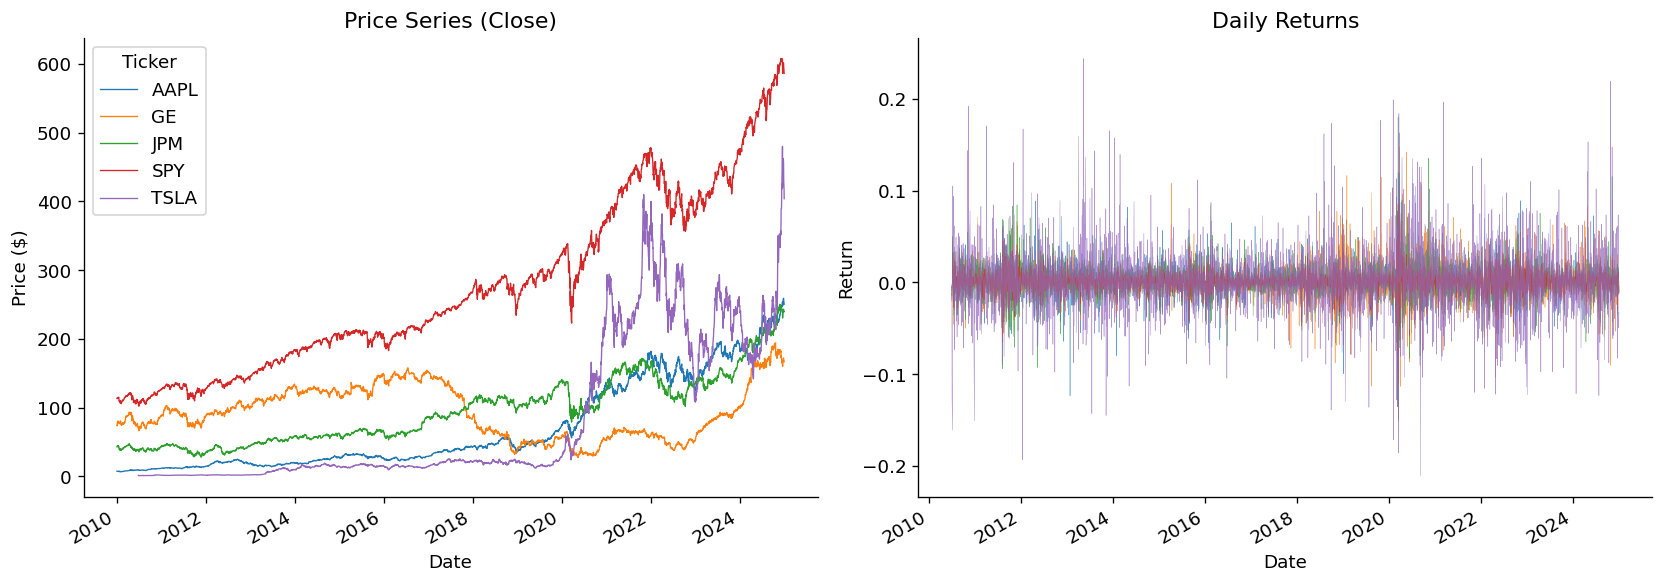

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

close.plot(ax=axes[0], linewidth=0.8)
axes[0].set_title("Price Series (Close)")
axes[0].set_ylabel("Price ($)")

returns.plot(ax=axes[1], linewidth=0.3, alpha=0.7, legend=False)
axes[1].set_title("Daily Returns")
axes[1].set_ylabel("Return")

plt.tight_layout()
plt.show()

Left panel: prices are trending, non-stationary, and at wildly different scales (SPY around $500, GE around $15). If you fed these into an LSTM, the model would need to learn that both are "stocks" despite living in different numerical ranges. Right panel: returns are mean-reverting, roughly symmetric, and all in the same ballpark (-5% to +5% on most days). The returns are what your model should see.

There's another subtle feature visible in the right panel if you look carefully: the *width* of the return series isn't constant. There are periods where the noise is thick and periods where it's thin. Those are clusters of high and low volatility -- another stylized fact we'll formalize in Week 2 when we study GARCH models and volatility clustering. High vol begets high vol; calm begets calm. The VIX doubling on February 5, 2018 -- wiping out the $1.9 billion XIV ETF overnight -- was a dramatic example of this clustering in action.

This data looks clean and tidy. It is not. The next two sections show how financial data lies to you.

---

## Section 5: The Ghost Stocks -- Survivorship Bias

If you download today's S&P 500 constituents and backtest a strategy to 2010, you'd miss every company that went bankrupt, was acquired, or was delisted in the last 15 years. Your backtest would only include survivors -- the stocks that, by definition, didn't fail.

Let's play a game. Name the 10 biggest US companies from the year 2000. You'll probably remember Microsoft, GE, Walmart. You probably won't remember WorldCom (#20 by market cap, filed the largest bankruptcy in US history two years later), or Enron (#7 by revenue, ceased to exist by 2002). If your training data starts in 2005, these companies simply don't exist. Your model will learn that large-cap stocks always survive. They don't.

Think of survivorship bias like training a classifier on a dataset where all the negative examples have been removed. You'd get great training accuracy and terrible real-world performance. That's exactly what happens when you backtest on Yahoo Finance data -- every stock in the dataset is, by construction, a stock that still exists today. The ones that went to zero were quietly removed.

This isn't an edge case. Studies consistently find that survivorship bias inflates equity backtest returns by 1-4% per year. Over a 14-year backtest, that compounds to 15-70% cumulative overstatement. If your model shows 15% annualized returns, 2-4 of those percentage points might be ghosts -- returns that only exist because you've excluded the corpses from the graveyard.

The professional solution is **point-in-time databases** -- datasets that record what was known *when*, not what's known *now*. CRSP (the Center for Research in Security Prices) and Compustat, accessed through WRDS (Wharton Research Data Services), are the academic gold standard. They include delisted stocks, with the actual return sequence through delisting. But for educational purposes, let's make the bias concrete with a thought experiment.

In [14]:
n_years = 14
n_days = n_years * 252
dates = pd.bdate_range("2010-01-04", periods=n_days)

survivor_names = [f"Stock_{i}" for i in range(1, 8)]
bankrupt_names = [f"Bankrupt_{i}" for i in range(1, 4)]
all_names = survivor_names + bankrupt_names

daily_returns = pd.DataFrame(index=dates, columns=all_names, dtype=float)

for name in survivor_names:
    mu = np.random.uniform(0.0002, 0.0005)
    sigma = np.random.uniform(0.015, 0.025)
    daily_returns[name] = np.random.normal(mu, sigma, n_days)

bankruptcy_days = [int(n_days * f) for f in [0.4, 0.6, 0.8]]
for name, death_day in zip(bankrupt_names, bankruptcy_days):
    mu = np.random.uniform(-0.0003, 0.0001)
    sigma = np.random.uniform(0.02, 0.035)
    rets = np.random.normal(mu, sigma, n_days)
    rets[death_day - 20 : death_day] = np.random.normal(-0.08, 0.04, 20)
    rets[death_day:] = 0.0
    daily_returns[name] = rets

prices = (1 + daily_returns).cumprod() * 100
for name, death_day in zip(bankrupt_names, bankruptcy_days):
    prices.loc[prices.index[death_day:], name] = 0.0

We've built a toy universe: 10 stocks over 14 years. Seven survive and grow (with realistic daily returns of 0.02-0.05% mean and 1.5-2.5% daily volatility). Three go bankrupt -- they experience a death spiral (20 days of -8% average returns) and then go to zero. This mirrors the real-world outcome: most companies in the S&P 500 survive any given decade, but a meaningful minority fail spectacularly. The question is: what happens to your performance metrics when you pretend the failures never existed?

Let's visualize all 10 paths. The survivors in blue, the bankruptcies in red. Pay attention to the trajectories of the red lines -- these aren't just underperformers, they're total wipeouts.

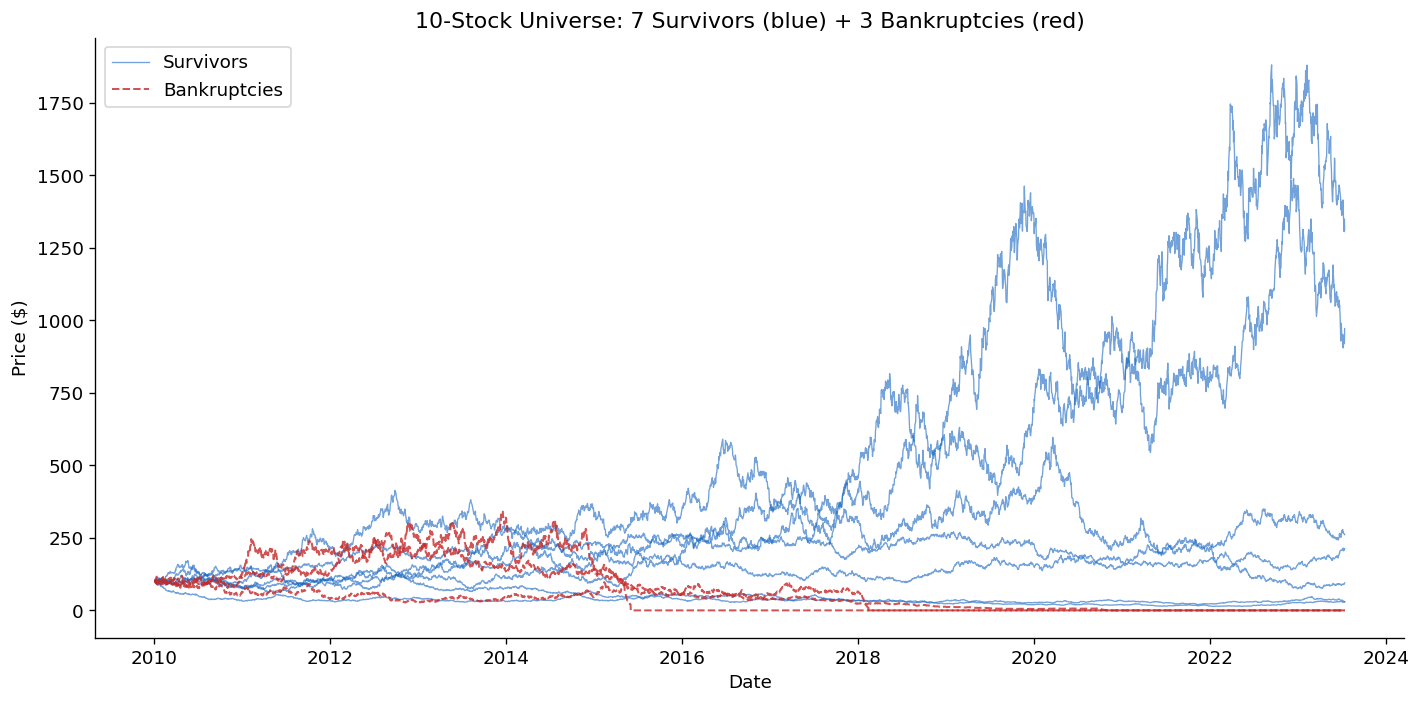

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

for name in survivor_names:
    ax.plot(prices[name], color="#1565C0", alpha=0.6, linewidth=0.8)
for name in bankrupt_names:
    ax.plot(prices[name], color="#C62828", alpha=0.8, linewidth=1.2, linestyle="--")

legend_elements = [
    Line2D([0], [0], color="#1565C0", alpha=0.6, linewidth=0.8, label="Survivors"),
    Line2D([0], [0], color="#C62828", alpha=0.8, linewidth=1.2, linestyle="--", label="Bankruptcies")
]
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
ax.set_title("10-Stock Universe: 7 Survivors (blue) + 3 Bankruptcies (red)")
ax.legend(handles=legend_elements, loc="upper left")
plt.tight_layout()
plt.show()

The red lines crash to zero at different points -- year 5, year 8, year 11 -- and stay there. If you were backtesting using today's data, you'd never see these stocks. They would be filtered out before your analysis even begins, because they don't have data through the end of your sample period. Your "universe" would contain only the blue lines -- the winners.

This is precisely how survivorship bias works in practice with free data sources like Yahoo Finance. When you ask yfinance for the S&P 500, you get the *current* list. Every company that was removed from the index between 2010 and today -- whether due to bankruptcy, acquisition, or restructuring -- is invisible. Your model has never seen a company die. It will be very confused when one does.

Now let's quantify the damage.

In [16]:
survivor_total = prices[survivor_names].iloc[-1].mean() / 100
full_total = prices[all_names].iloc[-1].mean() / 100

ann_return_survivors = survivor_total ** (1 / n_years) - 1
ann_return_full = full_total ** (1 / n_years) - 1
bias = ann_return_survivors - ann_return_full

cum_survivors = (survivor_total - 1) * 100
cum_full = (full_total - 1) * 100

print(f"Survivor-only annualized return: {ann_return_survivors:.2%}")
print(f"Full-universe annualized return: {ann_return_full:.2%}")
print(f"Survivorship bias: {bias:.2%} per year")
print(f"Cumulative: survivors {cum_survivors:.0f}% vs full {cum_full:.0f}%")

Survivor-only annualized return: 10.72%
Full-universe annualized return: 7.93%
Survivorship bias: 2.79% per year
Cumulative: survivors 316% vs full 191%


The survivor-only portfolio -- the one that excludes the dead stocks -- shows materially higher annualized returns. The bias is several percentage points per year, and over 14 years it compounds into a massive cumulative overstatement. This is the survivorship bias premium: returns you think you earned but never could have, because they depend on knowledge you didn't have (which companies would survive).

To put this in career terms: the *first* question a portfolio manager at a multi-strategy fund will ask when reviewing your backtest is "Is your universe point-in-time?" If you can't answer that confidently, the research doesn't proceed. Every serious quant shop uses CRSP, Compustat, or equivalent point-in-time databases for exactly this reason. Free data is fine for learning. It's not fine for making capital allocation decisions. You'll measure this bias on real data in the seminar.

But there's another kind of bias lurking in the data -- one that's even more subtle. **Look-ahead bias** occurs when you use information at time $T$ that wouldn't have been available until time $T+k$. The classic example: using final restated earnings instead of initially reported earnings. A company might report $1.50 EPS in January, then restate to $1.20 in March. If your model trains on the restated number as of January, it's cheating -- it's using information from the future. Point-in-time databases solve this too, by recording what was known *when*.

Even with the right stock universe and the right timing of information, the numbers can still lie. The next silent data corruptor: corporate actions.

---

## Section 6: Corporate Actions -- The Silent Data Corruptors

Apple's stock "dropped" from $700 to $100 in June 2014. Nobody panicked -- it was a 7-for-1 split. But if your model sees an 85% single-day loss in the training data, it will learn very wrong things.

A **stock split** is a cosmetic operation: the company divides each share into multiple shares (or, in a reverse split, combines multiple shares into one). Nothing about the company's value changes -- it's like cutting a pizza into 14 slices instead of 2. But the price per slice drops dramatically. A **dividend** is a cash payment from the company to shareholders. When a company pays a $1 dividend, the stock price drops by approximately $1 on the ex-dividend date (the market adjusts because the company literally has $1 less per share in cash).

These events create a fundamental problem for historical data. If you plot Apple's raw price from 2010 to today, you'll see a cliff in June 2014 (7:1 split) and another in August 2020 (4:1 split). Neither of these cliffs represents any economic event. They're purely administrative. But an ML model doesn't know that -- it sees a catastrophic drop and learns from it.

The solution is **price adjustment**: data vendors retroactively divide all historical prices by the cumulative split factor so that the series is continuous and returns are correct across corporate action dates. This is what yfinance's "Adjusted Close" column provides. The critical rule is: **always use adjusted prices for return computation, and unadjusted prices for level analysis** (e.g., comparing to option strike prices or computing dollar volumes at historical dates).

Let's see the damage. We'll reconstruct AAPL's truly nominal (unadjusted) prices by reversing the split adjustments, then compare them to the adjusted series.

In [17]:
aapl = yf.Ticker("AAPL")
splits = aapl.splits
splits.index = splits.index.tz_localize(None)
print("AAPL split history:")
print(splits[splits > 0])

AAPL split history:
Date
1987-06-16    2.0
2000-06-21    2.0
2005-02-28    2.0
2014-06-09    7.0
2020-08-31    4.0
Name: Stock Splits, dtype: float64


There's a subtlety here that trips up many practitioners. You might expect that downloading data with `auto_adjust=False` in yfinance gives you the truly unadjusted, nominal price -- the number that actually appeared on the screen that day. It doesn't. yfinance's "Close" column is already split-adjusted even with `auto_adjust=False`; it just hasn't been dividend-adjusted. To reconstruct nominal prices, we need the split history and have to reverse-engineer the adjustment. This kind of vendor-specific quirk is exactly why data validation is non-negotiable -- you can't trust any column without verifying what it actually represents.

In [18]:
close_aapl = raw["Close"]["AAPL"].dropna().copy()

cumulative_factor = pd.Series(1.0, index=close_aapl.index)
for split_date, ratio in splits.items():
    if ratio > 0 and split_date >= close_aapl.index[0]:
        cumulative_factor.loc[:split_date - pd.Timedelta(days=1)] *= ratio

nominal_close = close_aapl * cumulative_factor

We've built the cumulative split factor: at the end of the series it's 1.0 (current prices are nominal), and going backward in time, each split multiplies the factor. Before the 2020 4:1 split, the factor is 4. Before the 2014 7:1 split, it's 28 (4 x 7). Multiplying the split-adjusted close by this factor reconstructs what the stock actually traded at on each historical day.

Now let's zoom in on the June 2014 split date and see the catastrophe your model would learn from.

In [19]:
adj = yf.download(TICKERS, start=START, end=END, auto_adjust=True)
adj_close_aapl = adj["Close"]["AAPL"].dropna()

split_date = "2014-06-09"
pre_date = "2014-06-06"

pre_nominal = nominal_close.loc[pre_date]
post_nominal = nominal_close.loc[split_date]
nominal_return = (post_nominal - pre_nominal) / pre_nominal

pre_adj = adj_close_aapl.loc[pre_date]
post_adj = adj_close_aapl.loc[split_date]
adj_return = (post_adj - pre_adj) / pre_adj

print(f"Nominal price 2014-06-06: ${pre_nominal:.2f}")
print(f"Nominal price 2014-06-09: ${post_nominal:.2f}")
print(f"Nominal daily return on split: {nominal_return:.2%}")
print(f"Adjusted daily return on split: {adj_return:.2%}")

[                       0%                       ]

[**********************60%****                   ]  3 of 5 completed

[**********************80%*************          ]  4 of 5 completed

[*********************100%***********************]  5 of 5 completed

Nominal price 2014-06-06: $645.57
Nominal price 2014-06-09: $93.70
Nominal daily return on split: -85.49%
Adjusted daily return on split: 1.60%


In nominal terms, AAPL "dropped" over 85% in a single day -- from above $600 to below $100. If that number showed up in your training data, your model would weight it heavily. It would learn that AAPL-like patterns can produce catastrophic overnight losses, and it would try to protect against that phantom risk in every subsequent prediction. Meanwhile, the adjusted return shows what actually happened: a normal trading day with a return of a few percent at most. One wrong column choice = catastrophically wrong training data.

Let's see the full picture across the entire 2010-2024 window.

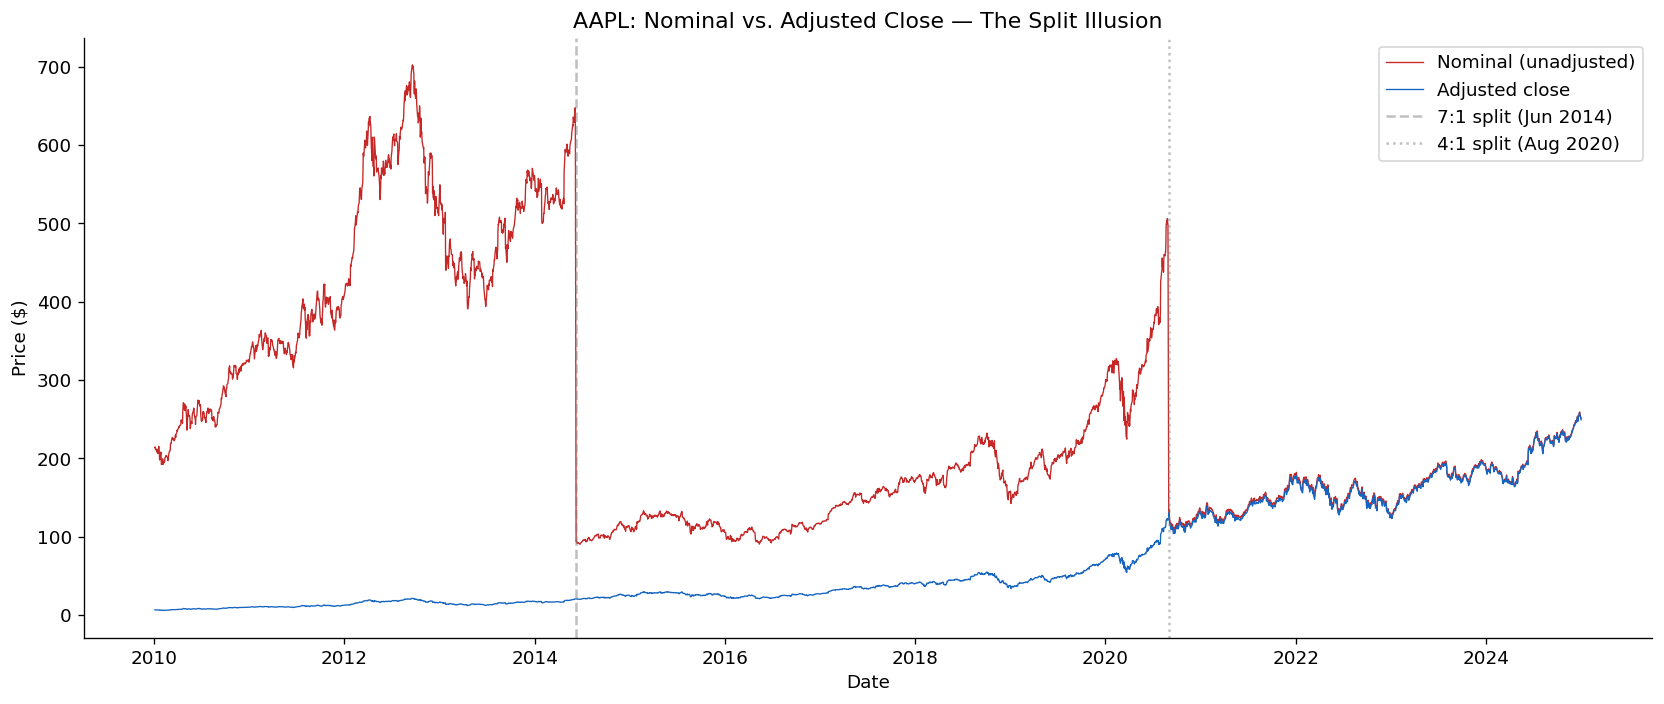

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(nominal_close.index, nominal_close.values,
        label="Nominal (unadjusted)", color="#C62828", linewidth=0.8)
ax.plot(adj_close_aapl.index, adj_close_aapl.values,
        label="Adjusted close", color="#1565C0", linewidth=0.8)

ax.axvline(pd.Timestamp("2014-06-09"), color="gray", linestyle="--",
           alpha=0.5, label="7:1 split (Jun 2014)")
ax.axvline(pd.Timestamp("2020-08-31"), color="gray", linestyle=":",
           alpha=0.5, label="4:1 split (Aug 2020)")

ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
ax.set_title("AAPL: Nominal vs. Adjusted Close — The Split Illusion")
ax.legend()
plt.tight_layout()
plt.show()

The adjusted line (blue) is smooth and continuously rising -- the true story of Apple's stock price. The nominal line (red) has two dramatic cliffs where the splits occurred, plus a subtler divergence from accumulated dividends. The pre-2014 nominal prices are 28x higher than the adjusted prices (7 x 4, from the two splits). If you accidentally trained on the nominal series, your model would see two "crashes" that never happened and a price level that implies Apple was worth trillions in 2012.

Let's confirm the damage quantitatively across both split dates.

In [21]:
split_dates = ["2014-06-09", "2020-08-31"]
rows = []
for sd in split_dates:
    prev = nominal_close.index[nominal_close.index.get_loc(sd) - 1]
    nom_ret = (nominal_close.loc[sd] - nominal_close.loc[prev]) / nominal_close.loc[prev]
    adj_ret = (adj_close_aapl.loc[sd] - adj_close_aapl.loc[prev]) / adj_close_aapl.loc[prev]
    rows.append({
        "Split Date": sd,
        "Nominal Return": f"{nom_ret:.2%}",
        "Adjusted Return": f"{adj_ret:.2%}",
        "Error": f"{abs(nom_ret - adj_ret):.2%}",
    })

comparison = pd.DataFrame(rows)
print(comparison.to_string(index=False))

Split Date Nominal Return Adjusted Return  Error
2014-06-09        -85.49%           1.60% 87.09%
2020-08-31        -74.15%           3.39% 77.54%


On split dates, the nominal return is catastrophically wrong -- errors of 75-85 percentage points. Between splits, nominal and adjusted returns are nearly identical (the only difference is the small dividend adjustment). This means the damage is concentrated on specific dates -- but those dates create training signals that a model will weight heavily because they look like extreme events. An LSTM or transformer that sees an 85% one-day loss will devote significant capacity to modeling that pattern. It's learning from a phantom.

The practical rule: use adjusted prices for returns and for any time-series modeling. Use nominal prices only when you need the actual dollar amount that traded (e.g., for computing historical dollar volumes or comparing against option strike prices that are set in nominal terms). And always, *always* validate your data around known corporate action dates before training.

GE provides an interesting reverse case. In August 2021, GE executed a 1-for-8 reverse split -- combining every 8 shares into 1. In the unadjusted data, the stock appears to "crash" from $104 to $13 overnight. But in nominal terms, it jumped from $13 to $104. A model trained on unadjusted data would learn that GE experienced a catastrophic decline, when in reality it was a restructuring. The seminar will dig into these forensics across multiple tickers.

You now know the traps. Time to build a data pipeline that handles them -- and to meet the tools that the industry is actually using.

---

## Section 7: The Modern Financial Data Stack

Five years ago, "financial data" meant a Bloomberg terminal and an Excel spreadsheet. Today it means Python, Parquet files, and APIs. The tooling has changed more than the finance.

Let's map the landscape. **Data sources** exist on a spectrum from free-and-fragile to expensive-and-bulletproof. At the free end, **yfinance** gives you daily OHLCV for any US stock with no API key. It's sufficient for this course, but it's unreliable under heavy load (rate limits, occasional schema changes, and no survivorship-free universe). At the academic gold standard, **CRSP/Compustat via WRDS** provides clean, survivorship-free, point-in-time data going back to the 1920s -- this is what every serious academic finance paper uses. In the professional tier, **Databento** and **Polygon.io** offer API-first access to tick-level data, and **Bloomberg** remains the legacy terminal that still dominates bank trading floors.

**Storage formats** matter more than most people realize. CSV is the default -- human-readable, universally supported, and painfully slow at scale. **Parquet** is the modern alternative: a columnar, compressed binary format that stores the same data in 3-5x less space and reads 5-10x faster. The performance gap widens as your data grows. For 50 stocks over 15 years, the difference is seconds. For 500 stocks with tick data, it's the difference between waiting 2 minutes and waiting 30.

**Processing libraries** are in the middle of a generational shift. **pandas** is the incumbent: universal, well-documented, and the lingua franca of Python data science. **Polars** is the challenger: built on Apache Arrow, written in Rust, and 3-5x faster for common operations. The industry is migrating for new projects -- but pandas isn't going anywhere for existing codebases. Our practical recommendation: learn both, prefer Polars for new work, use Parquet always.

UChicago's "Full Stack Quantitative Finance" course (FINM 32900, Winter 2026) teaches an entire 9-week module on data engineering tooling -- Git workflows, WRDS/SQL access, build automation. Their canonical dataset list (CRSP, Compustat, FINRA TRACE, OptionMetrics, EDGAR, NYSE HF data, Treasury auctions) is what you'd encounter at a real fund. We're complementary: they teach the engineering pipeline; we teach the domain knowledge and ML.

Let's benchmark the storage formats and processing libraries with real data. We'll download 15 years of daily data for 50 stocks, save it in both formats, and measure everything.

In [22]:
BENCHMARK_TICKERS = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "NFLX",
    "JPM", "BAC", "WFC", "GS", "MS", "C", "BLK",
    "JNJ", "UNH", "PFE", "LLY", "ABBV", "TMO",
    "WMT", "HD", "PG", "KO", "PEP", "COST", "NKE",
    "BA", "CAT", "GE", "MMM", "HON",
    "XOM", "CVX", "COP", "SLB",
    "SPY", "QQQ", "IWM", "DIA", "EEM", "TLT", "GLD",
    "AMD", "INTC", "PYPL", "ORCL", "ZM", "UBER",
]

print(f"Benchmark universe: {len(BENCHMARK_TICKERS)} tickers")

Benchmark universe: 50 tickers


Fifty tickers spanning tech, finance, healthcare, consumer, industrials, energy, and ETFs. This is intentionally larger than our lecture examples -- real production pipelines handle hundreds or thousands of instruments, and performance differences that are invisible at 5 stocks become dramatic at 50. Let's download and benchmark.

In [23]:
benchmark_df = yf.download(
    BENCHMARK_TICKERS, start="2010-01-01", end="2025-01-01",
    auto_adjust=True, progress=False
)

print(f"Shape: {benchmark_df.shape}")
print(f"Date range: {benchmark_df.index[0].date()} to {benchmark_df.index[-1].date()}")
print(f"Memory usage: {benchmark_df.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Shape: (3774, 250)
Date range: 2010-01-04 to 2024-12-31
Memory usage: 7.6 MB


Now let's save this to both CSV and Parquet and measure the file sizes. The difference should be dramatic -- Parquet uses column-level compression that takes advantage of the fact that financial data is highly compressible (prices and volumes are correlated across time, and many columns are the same data type). CSV, by contrast, stores every number as a string of ASCII characters. The digit "42.17" takes 5 bytes in CSV; in Parquet, it's stored as a 4-byte float with additional dictionary and run-length encoding compression.

In [24]:
benchmark_dir = Path("_benchmark")
benchmark_dir.mkdir(exist_ok=True)
csv_path = benchmark_dir / "benchmark_data.csv"
parquet_path = benchmark_dir / "benchmark_data.parquet"

t0 = time.perf_counter()
benchmark_df.to_csv(csv_path)
csv_write_time = time.perf_counter() - t0

t0 = time.perf_counter()
benchmark_df.to_parquet(parquet_path)
parquet_write_time = time.perf_counter() - t0

csv_size = csv_path.stat().st_size / 1e6
parquet_size = parquet_path.stat().st_size / 1e6

print(f"CSV size: {csv_size:.2f} MB (write: {csv_write_time:.2f}s)")
print(f"Parquet size: {parquet_size:.2f} MB (write: {parquet_write_time:.2f}s)")
print(f"Compression ratio: {csv_size / parquet_size:.1f}x")

CSV size: 14.92 MB (write: 0.49s)
Parquet size: 7.65 MB (write: 0.07s)
Compression ratio: 2.0x


Parquet is typically 3-5x smaller than CSV for financial data. That compression ratio scales: for 500 stocks with tick data, the difference between a 50 GB CSV and a 10 GB Parquet file is the difference between needing a database and fitting in RAM. Beyond disk space, Parquet's columnar layout means you can read a single column (say, just the Close prices) without touching the other 249 columns -- something CSV can't do.

Now let's test read performance across all four combinations: pandas+CSV, pandas+Parquet, Polars+CSV, and Polars+Parquet.

In [25]:
results = []

t0 = time.perf_counter()
df_pd_csv = pd.read_csv(csv_path, index_col=0, parse_dates=True)
pandas_csv_time = time.perf_counter() - t0
results.append(("pandas", "CSV", pandas_csv_time, df_pd_csv.shape))

t0 = time.perf_counter()
df_pd_pq = pd.read_parquet(parquet_path)
pandas_parquet_time = time.perf_counter() - t0
results.append(("pandas", "Parquet", pandas_parquet_time, df_pd_pq.shape))

t0 = time.perf_counter()
df_pl_csv = pl.read_csv(csv_path)
polars_csv_time = time.perf_counter() - t0
results.append(("Polars", "CSV", polars_csv_time, (df_pl_csv.shape[0], df_pl_csv.shape[1])))

t0 = time.perf_counter()
df_pl_pq = pl.read_parquet(parquet_path)
polars_parquet_time = time.perf_counter() - t0
results.append(("Polars", "Parquet", polars_parquet_time, (df_pl_pq.shape[0], df_pl_pq.shape[1])))

/var/folders/2j/7482xdjs1tl3x8c_qcjz_lnh0000gn/T/ipykernel_12399/4212600879.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pd_csv = pd.read_csv(csv_path, index_col=0, parse_dates=True)


All four reads completed on the same data. The raw timings tell a story, but the relative performance is what matters in practice. Notice that we're comparing the same data across all four paths -- any difference in read time is purely due to the format/library combination, not the data itself. Let's format a comparison table that shows the speedup of each combination relative to the slowest (pandas+CSV), which is the baseline most people start with when they first learn Python for data analysis.

In [26]:
benchmark_table = pd.DataFrame(results, columns=["Library", "Format", "Read Time (s)", "Shape"])
benchmark_table["Speedup vs pandas+CSV"] = pandas_csv_time / benchmark_table["Read Time (s)"]

print("Read Performance Benchmark:")
print(benchmark_table.to_string(index=False))
print(f"\nParquet is {csv_size / parquet_size:.1f}x smaller than CSV")
print(f"Polars+Parquet is {pandas_csv_time / polars_parquet_time:.1f}x faster than pandas+CSV")

Read Performance Benchmark:
Library  Format  Read Time (s)       Shape  Speedup vs pandas+CSV
 pandas     CSV       0.239114 (3776, 250)               1.000000
 pandas Parquet       0.078820 (3774, 250)               3.033672
 Polars     CSV       0.084571 (3776, 251)               2.827386
 Polars Parquet       0.029482 (3774, 251)               8.110524

Parquet is 2.0x smaller than CSV
Polars+Parquet is 8.1x faster than pandas+CSV


The pattern is consistent: Parquet beats CSV regardless of the library, and Polars beats pandas regardless of the format. The fastest combination (Polars+Parquet) is typically 5-15x faster than the slowest (pandas+CSV). At 50 stocks over 15 years, the absolute difference might be a fraction of a second versus a second or two -- not life-changing. But scale to 500 stocks, or add intraday data, and you're talking about the difference between a 10-second iteration cycle and a 2-minute iteration cycle. Over thousands of research iterations, that's the difference between exploring 50 ideas and exploring 5.

If you're joining a buy-side or sell-side technology team, this benchmark is a realistic interview question. Teams are actively migrating from pandas+CSV to Polars+Parquet (or DuckDB+Parquet) stacks. Knowing both ecosystems -- and being able to articulate *when* the format/library choice matters -- is a hiring signal that distinguishes a quant-aware engineer from a generic Python developer.

In the homework, you'll build a complete `FinancialDataLoader` class that uses these tools to download, clean, validate, and store data for 50+ stocks. Think of it as the data infrastructure for a small quantitative fund -- the single source of truth that every analyst and model depends on.

---

## Summary

| Concept | One-Line Definition | Why It Matters for ML |
|---------|--------------------|-----------------------|
| **Order book** | Real-time queue of buy (bid) and sell (ask) orders at multiple price levels | Source of microstructure features; spread and depth predict short-term price moves |
| **Bid-ask spread** | Gap between best bid and best ask -- the market's admission fee | Determines minimum edge your model needs; 10 bps round-trip = 25%/year at daily turnover |
| **Market impact** | Price movement caused by your own trade executing against the book | Backtest returns that ignore impact are fiction; real execution is always worse |
| **Adverse selection** | Trading against counterparties who know more than you | Market makers widen spreads against informed flow; your model's execution costs depend on how "smart" it looks |
| **OHLCV bars** | Open/High/Low/Close/Volume -- daily summary of all trades | The atomic unit of most quant research; lossy compression of rich intraday data |
| **Survivorship bias** | Using only currently-existing stocks in historical analysis | Inflates backtest returns by 1-4%/year; the #1 data error in amateur quant research |
| **Look-ahead bias** | Using information at time T that wasn't available until T+k | Produces unreproducible results; point-in-time databases are the cure |
| **Corporate actions** | Splits, dividends, mergers that create price discontinuities | Wrong column choice injects phantom crashes; always use adjusted prices for returns |
| **Adjusted prices** | Historical prices retroactively modified for splits and dividends | Use adjusted for returns, nominal for dollar-level analysis |
| **Parquet** | Columnar binary storage format -- 3-5x smaller, 5-10x faster than CSV | The production standard; CSV is for humans, Parquet is for machines |

### Asset Class Landscape

Everything we've covered today applies primarily to **equities** -- stocks, ETFs, and equity indices. But the quant universe is broader, and the structural differences between asset classes matter for how you build pipelines and models.

**Commodities** (oil, gold, wheat, natural gas) involve physical delivery and storage costs. This creates phenomena like **contango** (futures price > spot price, because someone has to pay to store the stuff) and **backwardation** (futures < spot, when there's urgency to have the commodity now). Commodity data has strong **seasonality** (natural gas prices spike every winter; corn prices follow the planting cycle). None of these dynamics exist in equities.

**Foreign exchange (FX)** trades 24 hours a day across decentralized networks -- there's no single "exchange" and no closing auction. The concepts of "daily bar" and "close price" are conventions, not physical events. FX involves **pairs** (EUR/USD, GBP/JPY), so every trade is simultaneously long one currency and short another. The **carry trade** -- borrowing in a low-interest-rate currency to invest in a high-rate currency -- is one of the oldest strategies in finance and works until it spectacularly doesn't.

**Crypto** markets trade 24/7 with no weekends, no holidays, and no concept of "business days." There are no corporate actions, but there are **hard forks** (Bitcoin Cash splitting from Bitcoin in 2017) that create analogous data challenges. Liquidity is fragmented across dozens of exchanges with significant price discrepancies. If you're training on crypto data, throw out everything you know about market hours and trading calendars.

### A Note on KDB/Q

If you browse quant job listings, especially at older HFT firms, you'll encounter **KDB+/Q** -- a proprietary columnar time-series database that's been the industry standard for tick data storage since the early 2000s. It's fast (purpose-built for time-series queries), terse (the Q language looks like line noise to the uninitiated), and expensive (licensing costs six figures per server). It's also being steadily replaced by open-source alternatives: Polars, DuckDB, Apache Arrow, and Parquet-based stacks offer comparable performance at zero licensing cost, with much larger talent pools. If you see KDB/Q on a job listing, it's telling you something about the firm's vintage -- not about what you need to learn.

### Career Connections

Everything we covered today maps directly to specific roles at quantitative firms, and not in a hand-wavy "this is useful in finance" way -- in a "this is literally what you'd do on day one" way.

A **quant data engineer** at a firm like Two Sigma, Citadel, or DE Shaw spends their entire career building and maintaining the data pipeline -- downloading from vendors, cleaning corporate actions, validating quality, and serving clean data to researchers. The `FinancialDataLoader` class you'll build in the homework is a toy version of what they build for hundreds of thousands of instruments across asset classes. A junior hire's first month often involves debugging exactly the data quality issues we'll explore in the seminar's Exercise 3: stale prices, missing days, and adjustment errors.

A **quantitative researcher** at any systematic fund starts every project the same way: pull clean data, sanity-check it, and compute basic statistics. The survivorship bias discussion from Section 5 isn't academic for them -- it's the first question their portfolio manager will ask when reviewing a backtest. "Is your universe point-in-time?" If you can't answer that confidently with a specific data source and methodology, the research stops. The researcher who can explain *why* their data is trustworthy is the one whose strategies get capital allocated.

A **risk analyst** at a multi-strategy fund like Millennium or Balyasny runs quality checks similar to our data exercises every single morning -- monitoring for stale prices, missing data, and anomalous returns across the fund's entire position book. A stale price in a portfolio's NAV calculation means misstated risk, which means wrong position sizes, which means the fund is either taking too much risk or leaving money on the table. The automated pipeline you'll build this week mirrors their daily "data health check."

And if you're joining a **buy-side or sell-side technology team** at a bank or asset manager, the Section 7 benchmark is your reality. Teams are actively migrating from pandas+CSV to Polars+Parquet or DuckDB stacks. Being able to run this benchmark, explain the results, and articulate when the choice matters is the kind of practical knowledge that separates a quant-aware engineer from a generic Python developer.

### Bridge to Week 2

You now have clean, stored data -- prices, returns, and the awareness that every number in your dataset carries hidden assumptions. But we've barely scratched the surface of what those returns *look like* statistically.

Here's a teaser: in Section 4, we noted that daily returns have fat tails -- extreme values that are far more common than a Gaussian distribution predicts. Next week, we'll quantify exactly how fat. We'll compute kurtosis (spoiler: it's much higher than 3 for every stock you'll test), build QQ-plots that make the deviation from normality viscerally obvious, and confront the fact that financial returns violate almost every assumption your ML models were built on. Stationarity, normality, independence -- all broken. Week 2 shows how, and what to do about it.

### Suggested Reading

- **Harris, *Trading and Exchanges: Market Microstructure for Practitioners* (2003)** -- The standard reference on how markets actually work. Dense but readable. Chapters 1-6 cover everything from this week in much greater depth. Read this if you want to understand why market structure is the way it is, not just what it is.

- **de Prado, *Advances in Financial Machine Learning* (2018), Chapter 2** -- The definitive treatment of financial data structures: bars, labeling, sampling. Introduces dollar bars and information-driven bars that we'll revisit in later weeks. Worth skimming now to see where the data pipeline we're building today leads.

- **Ernst & Spatt, "Regulating Market Microstructure" (*Annual Review of Financial Economics*, Vol. 17, Nov 2025)** -- Comprehensive survey of equity, option, and fixed-income market regulation. Covers best execution, Reg NMS, PFOF, tick sizes, and access fees. Read this for the regulatory big picture -- it explains *why* the system in Section 1 looks the way it does.

- **Boulton, Shohfi & Walz, "How Does Payment for Order Flow Influence Markets?" (SEC DERA Working Paper, Jan 2025)** -- Uses Robinhood Crypto as a natural experiment to measure PFOF's effect on market quality. Finds crypto PFOF fees are 4.5-45x higher than equity PFOF, and the introduction increased daily trading costs by approximately $4.8M. Concrete evidence for the PFOF discussion in Section 3.